# Descriptive Analysis
Aquest notebook té com a objectiu fer una anàlisi descriptiu de les dades relacionades amb la superfície mitjana en la compravenda de vivendes registrades a la ciutat de Barcelona. El motiu pel qual s'ha escollit crear un anàlisis descriptiu és perquè aquest tipus d'anàlisi permet entendre millor les dades i les seves característiques. Això ens permetrà identificar patrons i relacions entre les variables que en format de taula és impossible, així com també una visió general de les dades i identificar possibles tendències i comprovar si aquestes encaixen amb els tòpics dels barris que tractem o no.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, expr, lit, min, max, mean

In [3]:
# Sessió spark
spark = SparkSession.builder\
    .config("spark.jars", "duckdb.jar") \
    .getOrCreate()

24/04/25 20:54:16 WARN Utils: Your hostname, MacBook-Air-de-Olivia.local resolves to a loopback address: 127.0.0.1; using 192.168.1.135 instead (on interface en0)
24/04/25 20:54:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/04/25 20:54:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
# Carreguem les dades
districtes = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:duckdb:../exploited_zone/freshdata_exploited2.db") \
    .option("driver", "org.duckdb.DuckDBDriver") \
    .option("query", '''
        SELECT *
        FROM nova_base
    ''') \
    .load()
districtes.show()

+----+---------+-------------+--------------------+----------------------------------+------------------+
| Any|Trimestre|Nom_Districte|           Nom_Barri|Superfície_mitjana_(m2_construïts)|            Nombre|
+----+---------+-------------+--------------------+----------------------------------+------------------+
|2023|        1|       Gràcia|   la_Vila_de_Gràcia|                             Total|              80.5|
|2023|        2|       Gràcia|   la_Vila_de_Gràcia|                             Total| 81.30000305175781|
|2023|        3|       Gràcia|   la_Vila_de_Gràcia|                             Total|  83.0999984741211|
|2023|        1|       Gràcia|el_Camp_d_en_Gras...|                             Total| 77.30000305175781|
|2023|        2|       Gràcia|el_Camp_d_en_Gras...|                             Total|  71.4000015258789|
|2023|        3|       Gràcia|el_Camp_d_en_Gras...|                             Total|              68.5|
|2023|        1|       Gràcia|             el_

In [5]:
# Convertim a pandas
df = districtes.toPandas()

Tal com es mostra a continuació, podem veure si realment el preprocés generat anteriorment ha funcionat respecte els NAs i observar de quin tipus són les variables que tenim.

In [6]:
print("Información general del DataFrame: \n")
print(df.info())

Información general del DataFrame: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 6 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Any                                 876 non-null    object 
 1   Trimestre                           876 non-null    object 
 2   Nom_Districte                       876 non-null    object 
 3   Nom_Barri                           876 non-null    object 
 4   Superfície_mitjana_(m2_construïts)  876 non-null    object 
 5   Nombre                              876 non-null    float64
dtypes: float64(1), object(5)
memory usage: 41.2+ KB
None


Seguidament, agrupem pel tipus d'habitatge, variable "Superfície_mitjana_(m2_construïts)" i observem de cada tipus, el conteig de valor, la mitjana, la desviació estaàndard, el mínim, el primer quartil, la mediana, el tercer quartil i el màxim.

In [7]:
print("Estadística descriptiva agrupat pel tipus d'habitatge: \n")
print(df.groupby('Superfície_mitjana_(m2_construïts)').describe()['Nombre'])

Estadística descriptiva agrupat pel tipus d'habitatge: 

                                    count       mean        std        min  \
Superfície_mitjana_(m2_construïts)                                           
Habitatge nou lliure                219.0  83.411473  39.166685  23.000000   
Habitatge nou protegit              219.0  80.321328  22.785714  48.300000   
Habitatge usat                      219.0  79.152926  24.909658  40.700001   
Total                               219.0  79.478039  26.233325  41.299999   

                                          25%        50%        75%  \
Superfície_mitjana_(m2_construïts)                                    
Habitatge nou lliure                64.935714  73.199997  90.849998   
Habitatge nou protegit              66.487500  73.633334  83.462499   
Habitatge usat                      65.849998  72.199997  80.700001   
Total                               66.599998  72.199997  81.599998   

                                           max 

Un cop obtinguts els resultats, observem que revela diferències significatives entre els habitatges nous lliures, els habitatges nous protegits i els habitatges usats.

En primer lloc, la mitjana de la superfície construïda varia lleugerament entre els tres tipus d'habitatge, suggerint que, en general, els habitatges nous tenen una mida lleugerament superior als habitatges usats. No obstant això, la desviació estàndard ens indica la variabilitat en les dimensions dels habitatges dins de cada categoria, demostrant que hi ha una major diversitat de superfície en les dimensions dels habitatges nous lliures en comparació amb els altres dos tipus. Això es pot veure igual en els valors mínims i màxims on els habitatges nous lliures tenen un rang més ampli.

Per concloure, els habitatges nous lliures tendeixen a ser més espaiosos, amb una major variabilitat en les seves dimensions, mentre que els habitatges nous protegits mostren la menor variabilitat i els habitatges usats es troben en una posició intermèdia en termes de grandària i variabilitat.

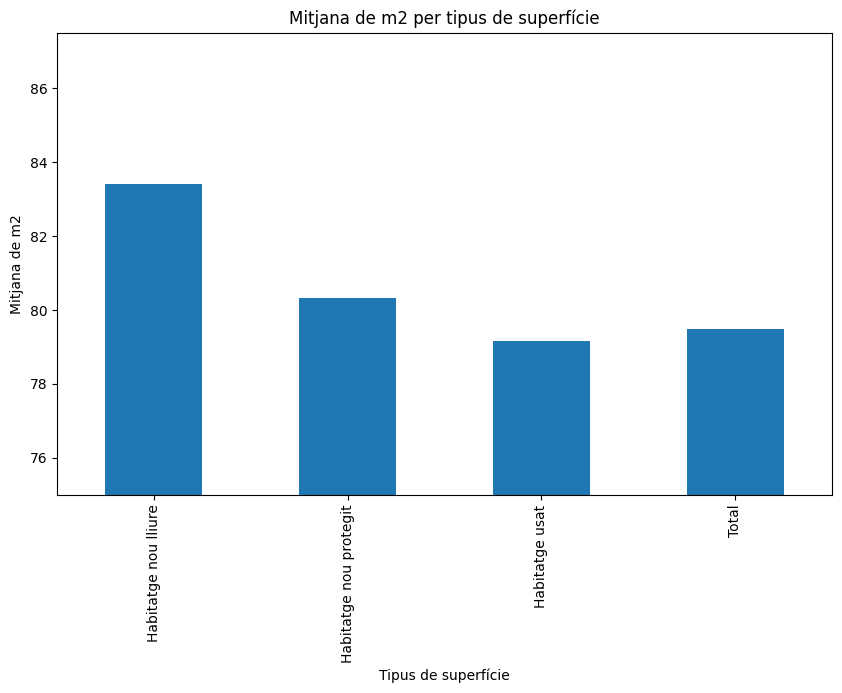

In [8]:
# Boxplot de la mitjana de Nombre pel tipus de superfície
plt.figure(figsize=(10, 6))
df.groupby('Superfície_mitjana_(m2_construïts)')['Nombre'].mean().plot(kind='bar')
plt.title('Mitjana de m2 per tipus de superfície')
plt.xlabel('Tipus de superfície')
plt.ylabel('Mitjana de m2')
plt.ylim(75, 87.5)
plt.show()

Tal com hem conclòs abans, és evident que hi ha una tendència en els habitatges nous lliures de ser més espaiosos en quant a superfície, tal com es mostra al histograma.

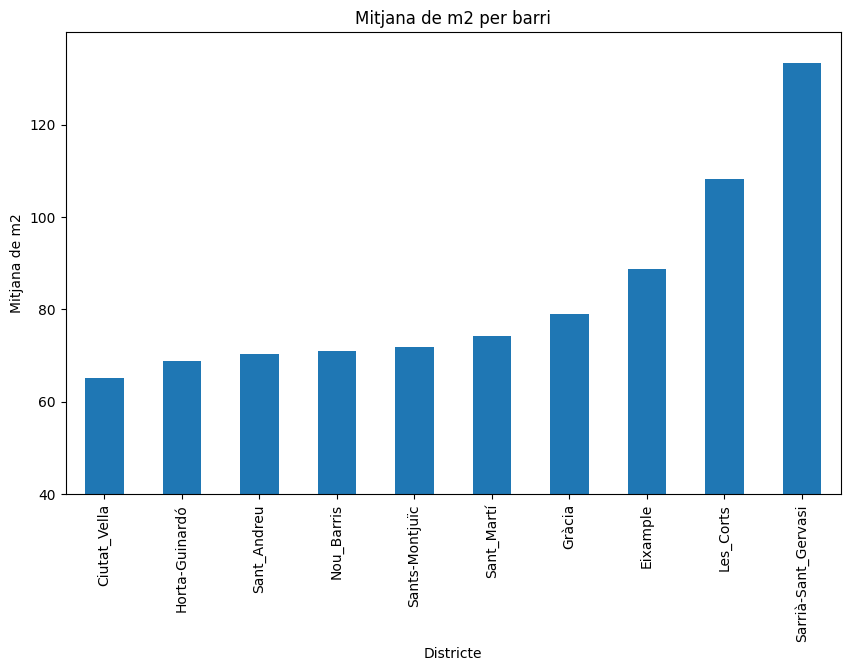

In [9]:
# Boxplot de la mitjana de Nombre per districte
plt.figure(figsize=(10, 6))
df[df['Superfície_mitjana_(m2_construïts)'] == 'Total'].groupby('Nom_Districte')['Nombre'].mean().sort_values().plot(kind='bar')
plt.title('Mitjana de m2 per barri')
plt.xlabel('Districte')
plt.ylabel('Mitjana de m2')
plt.ylim(40, )
plt.show()

/var/folders/k4/xwr8d2c95tb73c55cxv3rkc80000gn/T/ipykernel_4007/3813057950.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


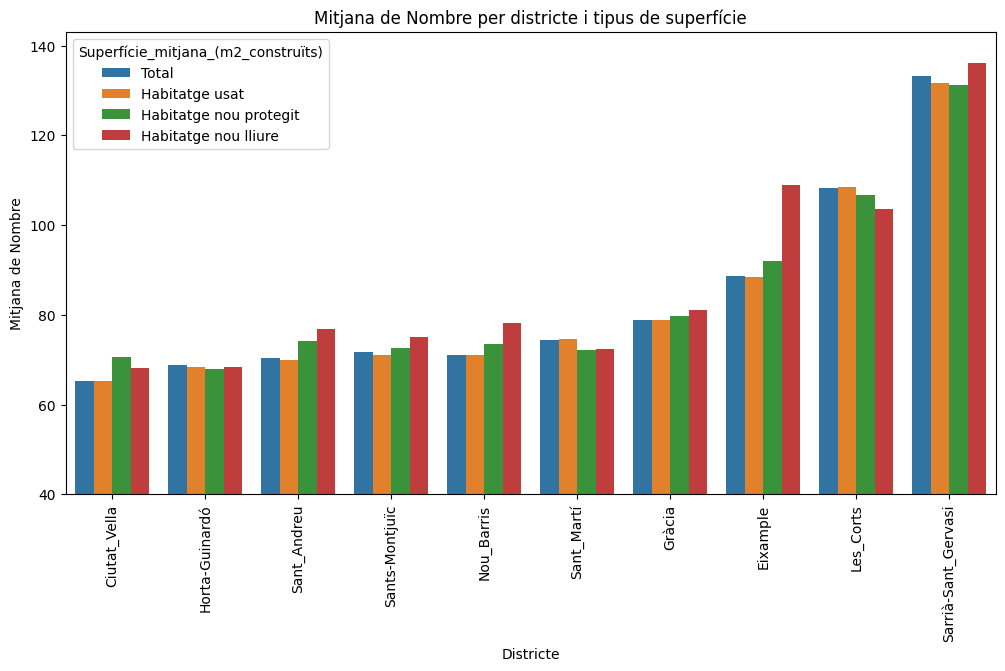

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

mean_m2_per_district = df.groupby(['Nom_Districte',"Superfície_mitjana_(m2_construïts)"])['Nombre'].mean().sort_values().reset_index()

# vull una gràfica que plasma 2 variables categòriques i una numèrica
plt.figure(figsize=(12, 6))
ax= sns.barplot(x='Nom_Districte', y='Nombre', hue='Superfície_mitjana_(m2_construïts)', data=mean_m2_per_district)
plt.title('Mitjana de Nombre per districte i tipus de superfície')
plt.xlabel('Districte')
plt.ylabel('Mitjana de Nombre')
plt.ylim(40, )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()


Finalment, en aquest darrer histograma, podem visualitzar la mitjana de la variable nombre dels diferents tipus de superfície mitjana a cada districte, permetent comparar fàcilment la distribució d'aquesta variable entre els districtes i els tipus de superfície. Al observar, es manté la mateixa distribució que l'anterior, on els districtes més esteriotipas com a adinerats, com Sarrià-Sant Gervasi i Les Corts, tenen una mitjana de superfície mitjana més gran que la resta de districtes. Això es pot veure en els districtes de Nou Barris i Sant Andreu, que tenen una mitjana de superfície mitjana més petita. També s'observa que la distribució dels diferents tipus d'habitatges és similar en tots els districtes, amb els habitatges nous lliures sent els més freqüents en la majoria. Tot i així cal destacar que en el districte de l'Eixample, els habitatges nous lliures són bastant més espaiosos que els altres tipus, indicant que les noves obres que s'hi han realitat són més grans que les ja existents.